In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [3]:
from pudl import mcoe

In [4]:
pudl_engine  = pudl.db_connect_pudl()

In [ ]:
def generation_pull_eia923(pudl_engine):
    # Convert the generation_eia923 table into a dataframe
    g9 = analysis.simple_select_with_pudl_plant_id('generation_eia923', pudl_engine)
    
    # Get yearly net generation by plant_id, year and generator_id
    g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
    g9_summed.reset_index(inplace=True)
    
    return(g9_summed)

In [5]:
g9_summed = mcoe.generation_pull_eia923(pudl_engine)

In [ ]:
def generators_pull_eia860(pudl_engine):
    # Convert the generators_eia860 table into a dataframe
    g8 = analysis.simple_select_with_pudl_plant_id('generators_eia860', pudl_engine)
    
    # create a generator table with mostly just the energy source
    # for use in manipulating values by energy source
    g8_es = g8[['plant_id_eia','generator_id', 'energy_source_1','report_year']]
    g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
    g8_es.drop_duplicates(['plant_id_eia','generator_id','report_year'], inplace=True)
    
    # create a consolidated energy source column
    # copy the energy course column and replace the content with consolidated values
    g8_es['energy_source_cons'] = g8_es.energy_source.copy()
    # use the energy source map in constants to replace each energy source with 
    for energy_source_cons in constants.energy_source_map.keys():
        for energy_source in constants.energy_source_map[energy_source_cons]:
            g8_es.loc[g8_es.energy_source==energy_source, 'energy_source_cons'] = energy_source_cons
            
    #Create a count of the types of energy sources
    g8_es_count = g8_es[['plant_id_eia','energy_source_cons','report_year']].drop_duplicates().groupby(['plant_id_eia','report_year']).count()
    g8_es_count.reset_index(inplace=True)
    g8_es_count = g8_es_count.rename(columns={'energy_source_cons':'energy_source_count'})
    g8_es = g8_es.merge(g8_es_count,how='left',on=['plant_id_eia','report_year'])
    
    # Cheating to duplicate 2011 EIA860 energy srouce for 2010 and 2009:
    g8_es_2010 = g8_es.loc[g8_es['report_year'] == 2011].copy()
    g8_es_2010.report_year.replace([2011], [2010], inplace=True)
    g8_es_2009 = g8_es.loc[g8_es['report_year'] == 2011].copy()
    g8_es_2009.report_year.replace([2011], [2009], inplace=True)
    g8_es_2016 = g8_es.loc[g8_es['report_year'] == 2015].copy()
    g8_es_2016.report_year.replace([2015], [2016], inplace=True)
    # Append 2009 and 2010
    g8_es = g8_es.append([g8_es_2009, g8_es_2010, g8_es_2016])
    
    return(g8_es)

In [6]:
g8_es = mcoe.generators_pull_eia860(pudl_engine)

In [ ]:
def fuel_reciept_costs_pull_eia923(pudl_engine):
    # Convert the fuel_receipts_costs_eia923 table into a dataframe
    frc9 = analysis.simple_select_with_pudl_plant_id('fuel_receipts_costs_eia923', pudl_engine)
    frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
    frc9['mmbtu'] =  (frc9['fuel_quantity'] * frc9['average_heat_content'])

    frc9['energy_source_cons'] = frc9.energy_source.copy()
    
    for energy_source_cons in constants.energy_source_map.keys():
        for energy_source in constants.energy_source_map[energy_source_cons]:
            frc9.loc[frc9.energy_source==energy_source, 'energy_source_cons'] = energy_source_cons 

    # Get yearly fuel cost by plant_id, year and energy_source
    frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id_eia','report_year','energy_source_cons'])
    frc9_summed = frc9_summed.reset_index()
    frc9_mmbtu_summed = analysis.yearly_sum_eia(frc9 , 'mmbtu', columns=['plant_id_eia','report_year','energy_source_cons'])
    frc9_mmbtu_summed = frc9_mmbtu_summed.reset_index()
    frc9_summed = frc9_mmbtu_summed.merge(frc9_summed)
    frc9_summed['fuel_cost_per_mmbtu_average'] = (frc9_summed.fuel_cost/frc9_summed.mmbtu)    

    # Get yearly fuel cost by plant_id and year
    # For use in calculating fuel cost for plants with one main energy soure
    frc9_summed_plant = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id_eia','report_year'])
    frc9_summed_plant = frc9_summed_plant.reset_index()
    frc9_mmbtu_summed_plant = analysis.yearly_sum_eia(frc9 , 'mmbtu', columns=['plant_id_eia','report_year'])
    frc9_mmbtu_summed_plant = frc9_mmbtu_summed_plant.reset_index()
    frc9_summed_plant = frc9_mmbtu_summed_plant.merge(frc9_summed_plant)
    frc9_summed_plant['fuel_cost_per_mmbtu_average'] = (frc9_summed_plant.fuel_cost/frc9_summed_plant.mmbtu)   

    return(frc9_summed, frc9_summed_plant)

In [7]:
frc9_summed, frc9_summed_plant = mcoe.fuel_reciept_costs_pull_eia923(pudl_engine)

Heat Rate Components

In [ ]:
def boiler_generator_pull_eia860(pudl_engine):
    # Convert the boiler_generator_assn_eia860 table into a dataframe
    bga8 = analysis.simple_select_with_pudl_plant_id('boiler_generator_assn_eia860', pudl_engine)
    bga8.drop(['id','operator_id'],axis=1, inplace=True)
    bga8.drop_duplicates(['plant_id_eia','boiler_id','generator_id'],inplace=True)
    
    return(bga8)

In [8]:
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)

In [ ]:
def boiler_fuel_pull_eia923(pudl_engine):
    # Convert the boiler_fuel_eia923 table into a dataframe
    bf9 = analysis.simple_select_with_pudl_plant_id('boiler_fuel_eia923', pudl_engine)
    bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
    # Get yearly fuel consumed by plant_id, year and boiler_id
    bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id_eia','report_year','boiler_id'])
    bf9_summed.reset_index(inplace=True)
    # Get yearly fuel consumed by plant_id, year and boiler_id
    bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id_eia','report_year'])
    bf9_plant_summed.reset_index(inplace=True)

    return(bf9_summed, bf9_plant_summed)

In [9]:
bf9_summed, bf9_plant_summed = mcoe.boiler_fuel_pull_eia923(pudl_engine)

In [10]:
# TODO: Move heat rate forumla to mcoe.py
heat_rate = analysis.heat_rate(bga8, g9_summed, bf9_summed, bf9_plant_summed, pudl_engine)

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([  1.00884934e+09,   2.18981702e+08,   2.24618810e+08,
          1.82972795e+08,   1.18515976e+08,   9.08115306e+07,
          5.56431791e+07,   4.39308321e+07,   3.11479319e+07,
          1.64996962e+07,   1.98257602e+07,   7.71683443e+06,
          7.63118641e+06,   6.16197292e+06,   3.81587313e+06,
          7.99611419e+06,   1.39846195e+07,   9.39864256e+06,
          1.11971090e+07,   4.10670667e+06,   8.47316747e+06,
          1.57410825e+07,   7.04950036e+07,   5.55232454e+07,
          6.20280733e+07,   4.43088230e+07,   2.36434126e+07,
          2.07701296e+07,   3.05094597e+07,   9.45092239e+07,
          3.38875909e+08,   5.00478955e+08,   1.42523826e+09,
          2.44124945e+09,   2.76283795e+09,   2.20789467e+09,
          1.55125030e+09,   1.24290656e+09,   6.91234255e+08,
          5.15498290e+08,   3.47689591e+08,   2.28507937e+08,
          1.66875499e+08,   9.47078316e+07,   8.01560055e+07,
          5.74312698e+07,   5.34869348e+07,   5.48130633e+07,
        

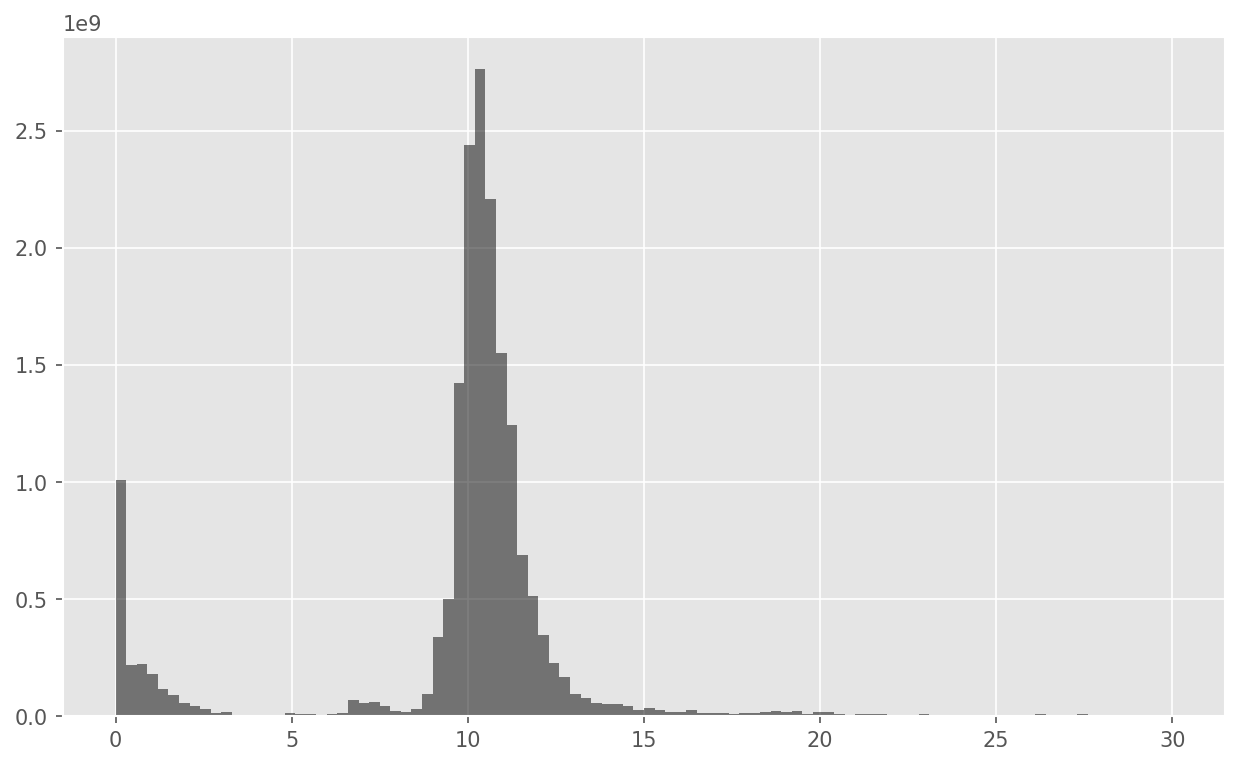

In [11]:
plt.hist(heat_rate.heat_rate_mmbtu_mwh, bins=100,range=(0,30), alpha=0.5, color='black', label="coal",weights=heat_rate.net_generation_mwh)


Guts inside the fuel cost formula

In [ ]:
def fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate):
    one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1]
    multi_fuel_plants = g8_es[g8_es['energy_source_count'] > 1]
    
    # one fuel plants
    net_gen_one_fuel = g9_summed.merge(one_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
    net_gen_one_fuel.dropna(inplace=True)

    # Merge this net_gen table with frc9_summed_plant to have
    # fuel_cost_per_mmbtu_total associated with generators
    fuel_cost_per_mmbtu_one_fuel = net_gen_one_fuel.merge(frc9_summed_plant,
                                        how='left',
                                        on=['plant_id_eia',
                                            'report_year'])

    fuel_cost_one_fuel = fuel_cost_per_mmbtu_one_fuel.merge(heat_rate[['plant_id_eia',
                                                     'report_year',
                                                     'generator_id',
                                                     'net_generation_mwh',
                                                     'heat_rate_mmbtu_mwh']],
                                          on=['plant_id_eia',
                                              'report_year',
                                              'generator_id',
                                              'net_generation_mwh'])

    # Calculate fuel cost per mwh using average fuel cost given year, plant,
    # fuel type; divide by generator-specific heat rate
    fuel_cost_one_fuel['fuel_cost_per_mwh'] = (fuel_cost_one_fuel['fuel_cost_per_mmbtu_average']
                                      * fuel_cost_one_fuel['heat_rate_mmbtu_mwh'])
    
    # mutli fuel plants 
    net_gen_multi_fuel = g9_summed.merge(multi_fuel_plants, how='left', on=[
                              'plant_id_eia', 'generator_id','report_year'])
    net_gen_multi_fuel.dropna(inplace=True)

    # Merge this net_gen table with frc9_summed to have
    # fuel_cost_per_mmbtu_total associated with generators
    fuel_cost_per_mmbtu_multi_fuel = net_gen_multi_fuel.merge(frc9_summed,
                                        how='left',
                                        on=['plant_id_eia',
                                            'report_year',
                                            'energy_source_cons'])

    fuel_cost_multi_fuel = fuel_cost_per_mmbtu_multi_fuel.merge(heat_rate[['plant_id_eia',
                                                     'report_year',
                                                     'generator_id',
                                                     'net_generation_mwh',
                                                     'heat_rate_mmbtu_mwh']],
                                          on=['plant_id_eia',
                                              'report_year',
                                              'generator_id',
                                              'net_generation_mwh'])

    # Calculate fuel cost per mwh using average fuel cost given year, plant,
    # fuel type; divide by generator-specific heat rate
    fuel_cost_multi_fuel['fuel_cost_per_mwh'] = (fuel_cost_multi_fuel['fuel_cost_per_mmbtu_average'] *
                                                 fuel_cost_multi_fuel['heat_rate_mmbtu_mwh'])

    # Squish them together!
    fuel_cost = fuel_cost_one_fuel.append(fuel_cost_multi_fuel)
    
    return(fuel_cost)

In [12]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

Prepping for simplifying fuel cost function

In [ ]:
# for use in simplifying the fuel cost funciton
plant_types = {'one_fuel': (g8_es[g8_es['energy_source_count'] == 1], frc9_summed_plant),
               'multi_fuel': (g8_es[g8_es['energy_source_count'] > 1], frc9_summed)}

In [ ]:
#plant_types['multi_fuel'][1]

In [ ]:
for plants in plant_types:
    print(plants)

In [ ]:
one_fuel_plants = g8_es[g8_es['energy_source_count'] == 1]

In [ ]:
multi_fuel_plants = g8_es[g8_es['energy_source_count'] > 1]

OhMiGosh Actually calculating Fuel Cost

In [ ]:
# Multi Fuel Method

In [ ]:
net_gen_multi_fuel = g9_summed.merge(multi_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_multi_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_multi_fuel = net_gen_multi_fuel.merge(frc9_summed,
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year',
                                        'energy_source_cons'])

fuel_cost_multi_fuel = fuel_cost_per_mmbtu_multi_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                          'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_multi_fuel['fuel_cost_per_mwh'] = (fuel_cost_multi_fuel['fuel_cost_per_mmbtu_average'] * fuel_cost_multi_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
fuel_cost_multi_fuel[fuel_cost_multi_fuel.fuel_cost_per_mwh.isnull()].count()

In [ ]:
# One Fuel Method

In [ ]:
net_gen_one_fuel = g9_summed.merge(one_fuel_plants, how='left', on=[
                          'plant_id_eia', 'generator_id','report_year'])
net_gen_one_fuel.dropna(inplace=True)

# Merge this net_gen table with frc9_summed_plant to have
# fuel_cost_per_mmbtu_total associated with generators
fuel_cost_per_mmbtu_one_fuel = net_gen_one_fuel.merge(frc9_summed_plant,
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])

fuel_cost_one_fuel = fuel_cost_per_mmbtu_one_fuel.merge(heat_rate[['plant_id_eia',
                                                 'report_year',
                                                 'generator_id',
                                                 'net_generation_mwh',
                                                 'heat_rate_mmbtu_mwh']],
                                      on=['plant_id_eia',
                                          'report_year',
                                          'generator_id',
                                          'net_generation_mwh'])

# Calculate fuel cost per mwh using average fuel cost given year, plant,
# fuel type; divide by generator-specific heat rate
fuel_cost_one_fuel['fuel_cost_per_mwh'] = (fuel_cost_one_fuel['fuel_cost_per_mmbtu_average']
                                  * fuel_cost_one_fuel['heat_rate_mmbtu_mwh'])

In [ ]:
# Squish them together!
fuel_cost = fuel_cost_one_fuel.append(fuel_cost_multi_fuel)

In [ ]:
fuel_cost_coal = fuel_cost[fuel_cost['energy_source_cons'] == 'coal']
fuel_cost_coal.describe()

In [ ]:
fuel_cost_gas = fuel_cost[fuel_cost['energy_source_cons'] == 'gas']
fuel_cost_gas.describe()

In [ ]:
fuel_cost_gas.net_generation_mwh.sum()

In [ ]:
fuel_cost_coal.describe()

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


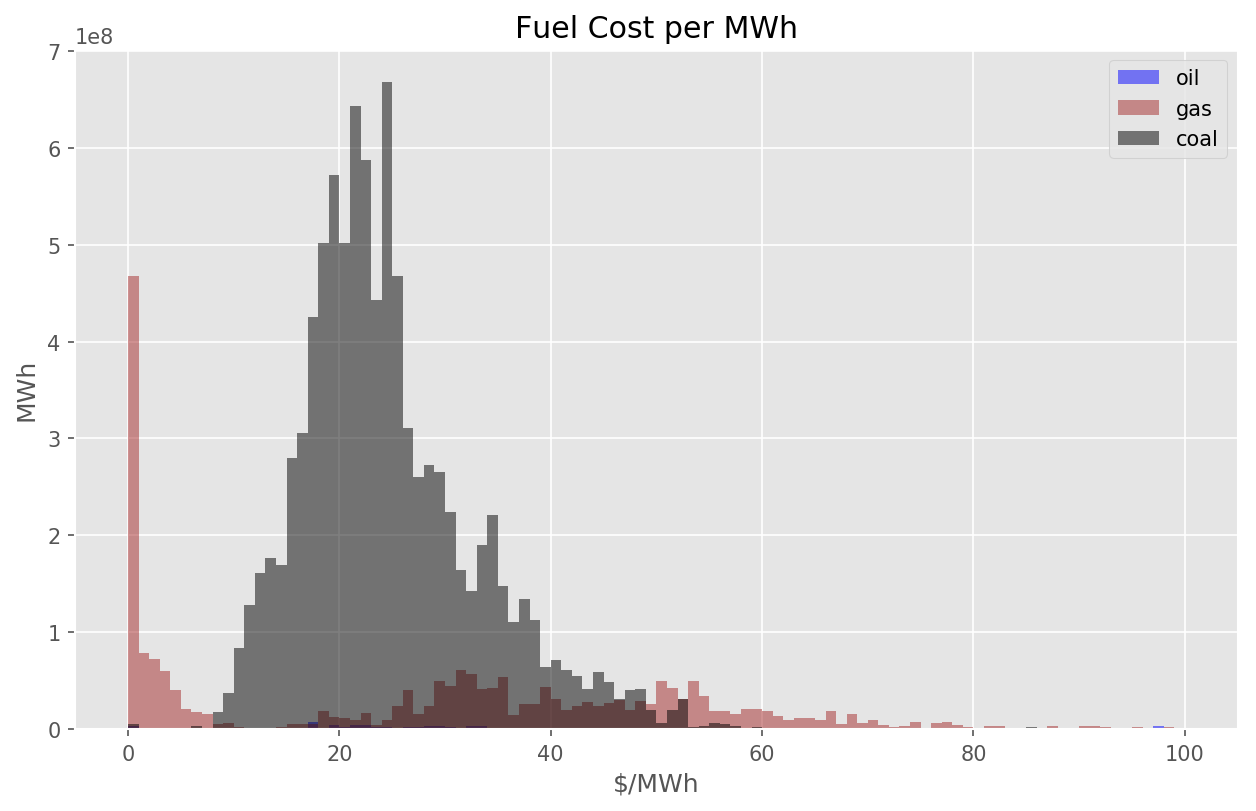

In [14]:
#plt.hist(mmbtu_one_fuel_bit.mmbtu_propotion_es, range=(.4,1), bins=100, alpha=0.5, color='green', label="BIT")
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='blue', label="oil",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'oil'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='brown', label="gas", weights=fuel_cost[fuel_cost['energy_source_cons'] == 'gas'].net_generation_mwh)
plt.hist(fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].fuel_cost_per_mwh, bins=100,range=(0,100), alpha=0.5, color='black', label="coal",weights=fuel_cost[fuel_cost['energy_source_cons'] == 'coal'].net_generation_mwh)
plt.xlabel("$/MWh")
plt.ylabel("MWh")
plt.title("Fuel Cost per MWh")
plt.legend()

In [15]:
fuel_cost_gas[fuel_cost_gas.fuel_cost.isnull()]

NameError: name 'fuel_cost_gas' is not defined

### Exploration of missing fuel costs.

In [16]:
# The frc9 pull is being done in a formula now from outputs and is thus not needed for calculating heat rate
# But it's useful for checking missing fuel costs from the original frc table
frc9 = analysis.simple_select_with_pudl_plant_id('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
frc9['mmbtu'] =  (frc9['fuel_quantity'] * frc9['average_heat_content'])

frc9['energy_source_cons'] = frc9.energy_source.copy()

for energy_source_cons in constants.energy_source_map.keys():
    for energy_source in constants.energy_source_map[energy_source_cons]:
        frc9.loc[frc9.energy_source==energy_source, 'energy_source_cons'] = energy_source_cons 

In [17]:
# Are we missing data from frc, or is there not cost info?
missing_in_frc = fuel_cost_one_fuel[fuel_cost_one_fuel.fuel_cost.isnull()]
missing_in_frc = missing_in_frc[['plant_id_eia','report_year']].drop_duplicates()
frc9['report_year'] = pd.to_datetime(frc9.report_date).dt.year
missing = missing_in_frc.merge(frc9,left_on=['plant_id_eia','report_year'],right_on=['plant_id_eia','report_year'])
missing[~missing.fuel_cost_per_mmbtu.isnull()]
# It apears that there are no missing frc records that actually have a fuel cost record. 

NameError: name 'fuel_cost_one_fuel' is not defined

### Exploration into portion of naturual gas for startup fuel from coal plants

In [ ]:
frc9_summed = frc9_summed.rename(columns={'energy_source':'energy_source_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source':'energy_source_plant'})

frc9_summed = frc9_summed.rename(columns={'energy_source_cons':'energy_source_cons_fuel'})
one_fuel_plants = one_fuel_plants.rename(columns={'energy_source_cons':'energy_source_cons_plant'})

In [ ]:
mmbtu_one_fuel_es = frc9_summed.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
# we'll merge with a total plant mmbtu, so we need to rename the per energy_source mmtbu
# we also need to drop all the NaN columns bc they are the multi fuel plants
# we also only need a few columns
mmbtu_one_fuel_es = mmbtu_one_fuel_es.rename(columns={'mmbtu': 'mmbtu_es'})\
                                     .dropna()\
                                     .drop(['fuel_cost',
                                            'fuel_cost_per_mmbtu_average',
                                            'generator_id',
                                            'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel_plant = frc9_summed_plant.merge(one_fuel_plants.drop_duplicates(subset=['plant_id_eia','energy_source_plant','report_year']),
                                    how='left',
                                    on=['plant_id_eia',
                                        'report_year'])
mmbtu_one_fuel_plant = mmbtu_one_fuel_plant.rename(columns={'mmbtu': 'mmbtu_plant'})\
                                           .dropna()\
                                           .drop(['fuel_cost',
                                                  'fuel_cost_per_mmbtu_average',
                                                  'generator_id',
                                                  'energy_source_count'],axis=1)

In [ ]:
mmbtu_one_fuel = mmbtu_one_fuel_es.merge(mmbtu_one_fuel_plant,how='left',on=['plant_id_eia','report_year','energy_source_plant','energy_source_cons_plant'])


In [ ]:
mmbtu_one_fuel['mmbtu_propotion_es'] = mmbtu_one_fuel['mmbtu_es']/mmbtu_one_fuel['mmbtu_plant']

In [ ]:
mmbtu_one_fuel[mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal'].count()

In [ ]:
mmbtu_one_fuel_coal = mmbtu_one_fuel[(mmbtu_one_fuel['energy_source_cons_plant'] == 'coal') & 
                                    (mmbtu_one_fuel['energy_source_cons_fuel'] == 'coal')]

In [ ]:
mmbtu_one_fuel_coal[mmbtu_one_fuel_coal['mmbtu_propotion_es'] < .8].drop_duplicates(subset=['plant_id_eia'])

In [ ]:
mmbtu_one_fuel_coal.describe()

In [ ]:
plt.hist(mmbtu_one_fuel_coal.mmbtu_propotion_es, range=(.9,1), bins=100, alpha=0.5, color='black', label="coal")
plt.xlabel("Proportion")
plt.ylabel("Number of records")
plt.title("Proportion of Coal Receipts")
plt.legend()

Additional problem exploration...

In [ ]:
# There are some generators out of 27,000 that don't have records in the generators table
# A chunk of these appear to be plants that are retired mid-way through a year
# this will be fixed when we pull in the retired tab into the generators table.
# A chunk of these appear to be genertors added after 2016. This should be fiexed
# when we pull in 2016 data.
test = g9_summed.merge(net_gen_one_fuel.append(net_gen_mutli_fuel),how='left')
test[test.energy_source.isnull()].count()